<a href="https://colab.research.google.com/github/FabioPojo1987/FabioPojo1987-MVP_2_DATA_SCIENCE_PUC_RIO/blob/main/MVP_2_DATA_SCIENCE_PUC_Rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto de MVP da 2ª Sprint do curso de Ciência de Dados na PUC-Rio (por Fabio Pojo de Almeida).**


Este projeto se trata na construção de um modelo de aprendizado de máquina ("machine learning") para criar insights sobre como ocorre a variação de dados dos valores das ações do Google no Mercado de Ações.

Onde foi utilizado um recorte temporal compreendido entre os anos de 2010 e 2023

Este projeto está baseado em um modelo de "Rede Neural Recorrente" e está usando de referência os dados presentes nas planilhas csv

Para isso, foi decidido um exemplo onde esses dados foram separados em duas bases em 2 arquivos diferentes: 1- base de treino e 2- teste (a faixa da base de teste tem como referência um período de 3 semanas, ou 21 dias)

- A base de dados utilizada para os valores das ações do Google (Alphabet.inc.) foi obtida no site Yahoo Finance: https://finance.yahoo.com/quote/GOOG/history/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAHHEUNSIQe0UmTDWqYQbZ7mz4LE0uvam08jtyQ6_-K3WLS0MWVFvTRHoTQHt4fKdL0dLQV7jOcO7UERQTxQp0oukrXzng6z5MpktzGM9uscHlh5tl_vIgsttiyA-lfF--d3FWaIU-vIpjBkyJSM3W-BRwEt6eJqX5Z7U_ko_9nOv

- Encontrando-se disponível através do Kaggle em: https://www.kaggle.com/datasets/alirezajavid1999/google-stock-2010-2023/download?datasetVersionNumber=1

- E tambem em: https://www.gigasheet.com/sample-data/google-stock-2010-2023

Campos do dataset :

1.   Date - Data/dia do mês
2.   Open - Valor das ações na Abertura
3.   High - Valor mais alto do dia ("Pico")
4.   Low - Valor mais baixo ("vale")
5.   Volume - Volume a ser Negociado
6.   High - Close : Valor (a maior) no momento de fechamento


Objetivo - Usar os dados de treino para prever os valores que estão nos dados de teste, o objetivo é comparar a previsão do modelo com o que de fato aconteceu.





In [2]:
# 1º Passo: Importar as bibliotecas necessárias
import numpy as np # vai ser usado pra criar os arrays
import matplotlib.pyplot as plt # para gerar graficos
import pandas as pd

In [3]:
#2º Passo: Obter a fonte de dados de treinamento
url_dados = 'https://raw.githubusercontent.com/FabioPojo1987/FabioPojo1987-MVP_2_DATA_SCIENCE_PUC_RIO/main/Google_Stock_Train%20(2010-2022).csv'

In [4]:
# 3º Passo: Importar os dados
dataset_train = pd.read_csv(url_dados)
training_set = dataset_train.iloc[:, 1:2].values # separar apenas os atributos
# que usaremos no modelo

In [5]:
# 4º Passo Transformação e Normalização dos dados
from sklearn.preprocessing import MinMaxScaler # estabelecer valores numa mesma escala
sc = MinMaxScaler(feature_range = (0, 1)) # define normalização (será entre 0 e 1)
training_set_scaled = sc.fit_transform(training_set) # aplicar os dados na normalização

In [6]:
#5º Passo : Definindo as Estruturas de dados
#com 60 intervalos de tempo, vamos pegar 60 dias pra ter uma ideia de prever a proxima saida
X_train = [] # cria lista do python pra pegar os 60 dias
y_train = [] # essa lista preve o proximo dia
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [7]:
# 7º Passo: Colocar os dados no formatos que o Keras exige, ele precisa estar em três dimensões
# batch_size, timesteps( intervalos de treinamento, e numero de indicadores que serão usados)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
# 8º Passo: Importando bibliotecas do Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [9]:
# 9º Passo: Inicializar a rede neural
regressor = Sequential()
#Criando as camadas
#1
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
#2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#3
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#4
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# camada de saída
regressor.add(Dense(units = 1))

In [10]:
# 10º Passo: Fazer a Compilação da rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
#Treinando
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 12s 100ms/step - loss: 4.8461e-04
Epoch 2/100
38/38 [==============================] - 4s 98ms/step - loss: 1.1045e-04
Epoch 3/100
38/38 [==============================] - 5s 143ms/step - loss: 1.0135e-04
Epoch 4/100
38/38 [==============================] - 4s 111ms/step - loss: 1.0369e-04
Epoch 5/100
38/38 [==============================] - 5s 142ms/step - loss: 9.5273e-05
Epoch 6/100
38/38 [==============================] - 7s 182ms/step - loss: 9.3466e-05
Epoch 7/100
38/38 [==============================] - 4s 101ms/step - loss: 7.6624e-05
Epoch 8/100
38/38 [==============================] - 5s 123ms/step - loss: 7.3101e-05
Epoch 9/100
38/38 [==============================] - 4s 107ms/step - loss: 6.9732e-05
Epoch 10/100
38/38 [==============================] - 4s 101ms/step - loss: 6.4333e-05
Epoch 11/100
38/38 [==============================] - 5s 118ms/step - loss: 6.0888e-05
Epoch 12/100
38/38 [==============================] 

In [ ]:
# 11º Passo: Obter dados de teste
url_dados2 = 'https://github.com/FabioPojo1987/FabioPojo1987-MVP_2_DATA_SCIENCE_PUC_RIO/blob/main/Google_Stock_Price_(01-2010_-_12-2023).csv'

In [11]:
# 12º Passo: Obtendo os dados reais entre 2010 a 2023
import pandas as pd
dataset_test = pd.read_csv('Google_Stock_Price_(01-2010_-_12-2023).csv')
real_stock_price = dataset_test.iloc[:, 1:2].values # pegar apenas coluna de saída, a Open

In [14]:
# 13º Passo: Obtendo os dados previstos
import pandas as pd
import numpy as np
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total.values
inputs = inputs.reshape(-1, 1)
sc = MinMaxScaler(feature_range=(0, 1))
inputs = sc.fit_transform(inputs)
X_test = []
for i in range(len(dataset_total) - len(dataset_test), len(dataset_total)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

111/111 [==============================] - 8s 53ms/step


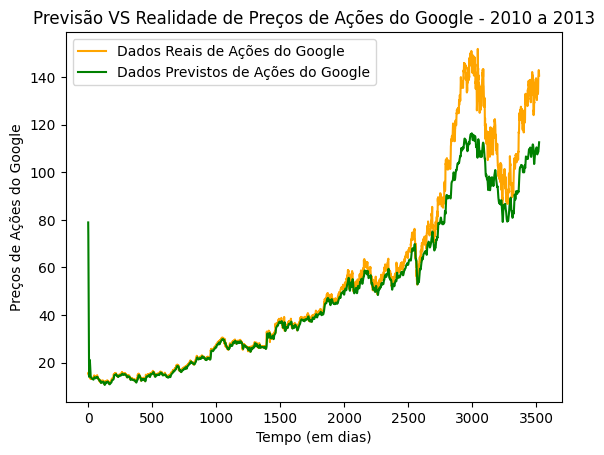

In [17]:
# 14º Passo: Visualizando os Resultados
plt.plot(real_stock_price, color = 'orange', label = 'Dados Reais de Ações do Google')
plt.plot(predicted_stock_price, color = 'green', label = 'Dados Previstos de Ações do Google')
plt.title('Previsão VS Realidade de Preços de Ações do Google - 2010 a 2013')
plt.xlabel('Tempo (em dias)')
plt.ylabel('Preços de Ações do Google')
plt.legend()
plt.show()

A partir deste trabalho, foi possível observar que o sistema de previsão até que conseguiu obter uma tendência bem interessante, especialmente sendo bem útil para pessoas que lidam com o mercado de ações na Bolsa de Valores.

Contudo, ainda assim o algoritmo não conseguiu acertar as tendências. Errou em parte.

Pois, utilizar esse tipo de metodologia (para tentar prever dados de ações financeiras) é algo bastante complexo e demanda muito tempo e poder de processamento para ter mais eficiência e precisão.

Fora que, devido ao fato de se lidar com informações de risco, não é aconselhavel de se basear os investimentos de capital em modelos de simulação como esse.

Porém, pode-se utilizar esse tipo de metodologia pra estudar e aprender novas possibilidades de previsões e de tendência.